In [22]:
import os

In [23]:
import sys
scripts_dir = os.path.join(os.path.dirname(os.path.abspath('')), 'scripts')
if not scripts_dir in sys.path:
    sys.path.append(scripts_dir)

In [24]:
import networkx as nx
from get_graph import get_digraph

g: nx.DiGraph = get_digraph()

In [25]:
import dgl

G = dgl.from_networkx(g)

# Using only text embeddings

In [53]:
import numpy as np
word_embs = np.load(os.path.join(os.pardir, 'embeddings.npy'))

In [55]:
word_embs.shape

(27373, 50)

In [54]:
import torch
G.ndata['word_embs'] = torch.from_numpy(word_embs)

DGLError: Expect number of features to match number of nodes (len(u)). Got 27373 and 27376 instead.

In [28]:
from train_test_split import make_split

adj_train, train_edges, train_edges_false, \
        val_edges, val_edges_false, test_edges, test_edges_false = make_split(nx.to_scipy_sparse_array(g))

KeyboardInterrupt: 

In [ ]:
train = torch.cat([torch.as_tensor(train_edges), torch.as_tensor(train_edges_false)])

train_u = train[:, 0]
train_v = train[:, 1]
train_label = torch.cat([torch.ones(len(train_edges)), torch.zeros(len(train_edges_false))])

In [ ]:
test = torch.cat([torch.as_tensor(test_edges), torch.as_tensor(test_edges_false)])

test_u = test[:, 0]
test_v = test[:, 1]
test_label = torch.cat([torch.ones(len(test_edges)), torch.zeros(len(test_edges_false))])

In [ ]:
val = torch.cat([torch.as_tensor(val_edges), torch.as_tensor(val_edges_false)])

val_u = val[:, 0]
val_v = val[:, 1]
val_label = torch.cat([torch.ones(len(val_edges)), torch.zeros(len(val_edges_false))])

In [52]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train_loop(model, optimizer, n_epochs, feature):
    train_losses = []
    test_losses = []
    accuracies = []

    for e in range(n_epochs):
        logits = model(G, G.ndata[feature].float())
        pred = torch.sigmoid((logits[train_u] * logits[train_v]).sum(dim=1))
        train_loss = F.binary_cross_entropy(pred, train_label)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            test_pred = torch.sigmoid((logits[test_u] * logits[test_v]).sum(dim=1))
            test_loss = F.binary_cross_entropy(test_pred, test_label)
            val_pred = torch.sigmoid((logits[val_u] * logits[val_v]).sum(dim=1))
            accuracy = ((val_pred >= 0.5) == val_label).sum().item() / len(val_label)
            accuracies.append(accuracy)
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

        if e % 5 == 0:
            clear_output(True)
            plt.figure(figsize=(12, 6))
            
            # График потерь
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Train Loss')
            plt.plot(test_losses, label='Test Loss')
            plt.ylim(0, max(max(train_losses), max(test_losses)) * 1.1)
            plt.title('Loss')
            plt.legend()
            
            # График точности
            plt.subplot(1, 2, 2)
            plt.plot(accuracies, label='Accuracy', color='orange')
            plt.ylim(0, 1)
            plt.title('Accuracy')
            plt.legend()
            
            plt.show()
            
            print(f'Epoch {e}, Training Loss: {train_loss.item()}, Test Loss: {test_loss.item()}, Accuracy: {accuracy:.4f}')


In [ ]:
from gat import GraphSAGE

text_based = GraphSAGE(50, 128)
optimizer = torch.optim.Adam(text_based.parameters(), lr=0.001)

In [49]:
train_loop(text_based, optimizer, 100, 'word_embs')

NameError: name 'text_based' is not defined

In [ ]:
logits = text_based(G, G.ndata['word_embs'].float())
pred = torch.sigmoid((logits[val_u] * logits[val_v]).sum(dim=1))
print('Accuracy', ((pred >= 0.5) == val_label).sum().item() / len(pred))

Accuracy 0.5361339600470035


# Using only graph embeddings

In [29]:
from gensim.models import KeyedVectors

embs_path = os.path.join(os.pardir, 'n2c_embs')
node_embeddings = KeyedVectors.load_word2vec_format(embs_path)

In [41]:
G.ndata['node_embs'] = torch.tensor(
    [node_embeddings[node.item()] for node in list(G.nodes())]
)

In [45]:
graph_based = GraphSAGE(64, 128)
optimizer = torch.optim.Adam(graph_based.parameters(), lr=0.001)

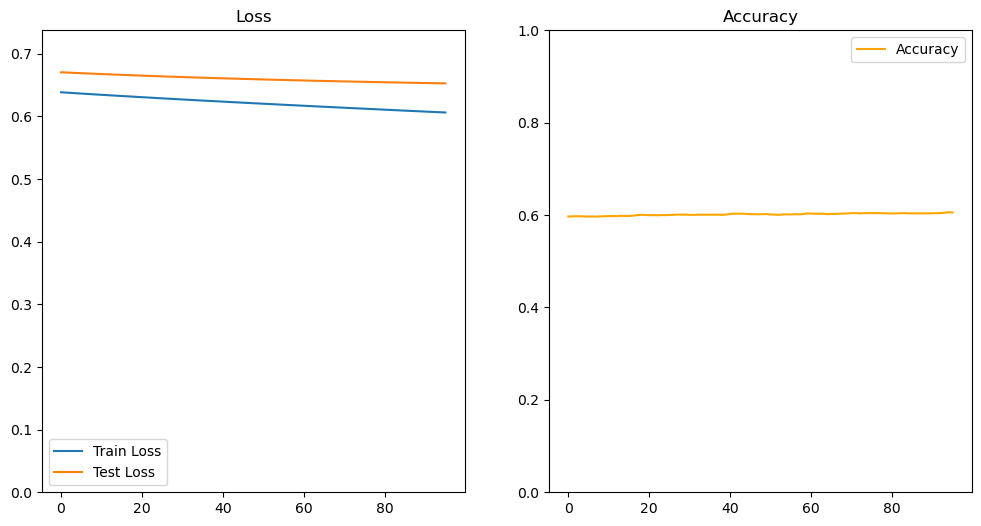

Epoch 95, Training Loss: 0.6063652038574219, Test Loss: 0.6528975367546082, Accuracy: 0.6058


In [56]:
train_loop(graph_based, optimizer, 100, 'node_embs')

In [51]:
logits = graph_based(G, G.ndata['node_embs'].float())
pred = torch.sigmoid((logits[val_u] * logits[val_v]).sum(dim=1))
print('Accuracy', ((pred >= 0.5) == val_label).sum().item() / len(pred))

Accuracy 0.5969447708578144
